In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
train_path = os.path.join('disaster_or_not', 'train.csv')
train_df = pd.read_csv(train_path)
test_path = os.path.join('disaster_or_not', 'test.csv')
test_df = pd.read_csv(test_path)
print('Shape of data: ', train_df.shape)
train_df.head()

Shape of data:  (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
print('Train data:')
print((train_df.isna().sum() / train_df.count()).round(4) * 100)
print()
print('Test data:')
print((test_df.isna().sum() / test_df.count()).round(4) * 100)

Train data:
id           0.00
keyword      0.81
location    49.86
text         0.00
target       0.00
dtype: float64

Test data:
id           0.0
keyword      0.8
location    51.2
text         0.0
dtype: float64


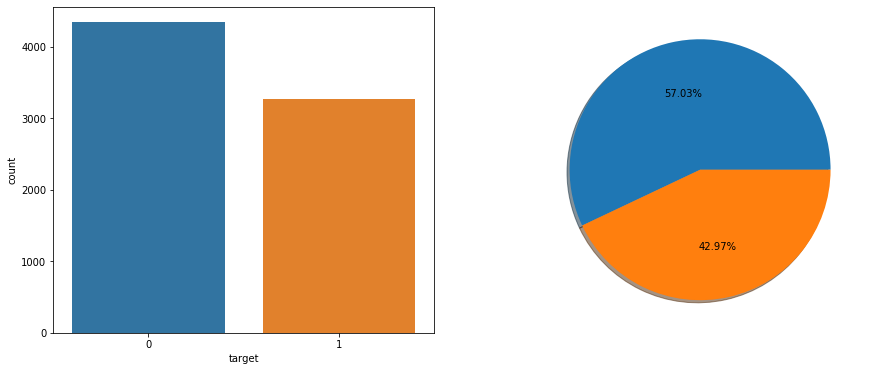

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sns.countplot(train_df['target'], ax=ax1)
ax2.pie(train_df['target'].value_counts(), autopct=lambda x: f'{x.round(2)}%', shadow=True);

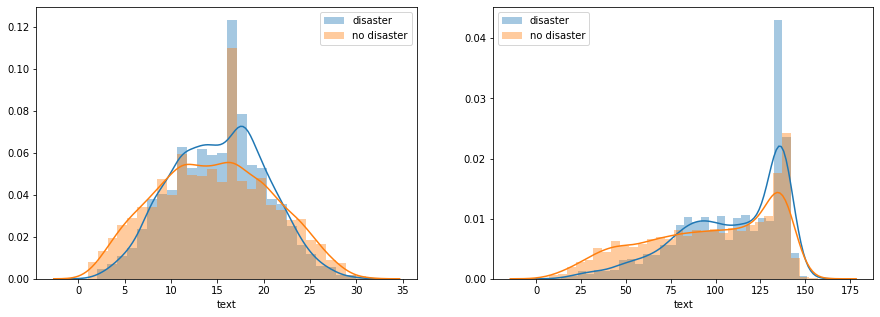

In [29]:
disaster = train_df.loc[train_df['target']==1]
no_disaster = train_df.loc[train_df['target']==0]
fig, ax = plt.subplots(1, 2, figsize=(15,5))

sns.distplot(disaster['text'].str.split().apply(lambda x: len(x)), ax=ax[0], label='disaster')
sns.distplot(no_disaster['text'].str.split().apply(lambda x: len(x)), ax=ax[0], label='no disaster')
ax[0].legend()

sns.distplot(disaster['text'].str.len(), ax=ax[1], bins=30, label='disaster')
sns.distplot(no_disaster['text'].str.len(), ax=ax[1], bins=30, label='no disaster')
ax[1].legend()

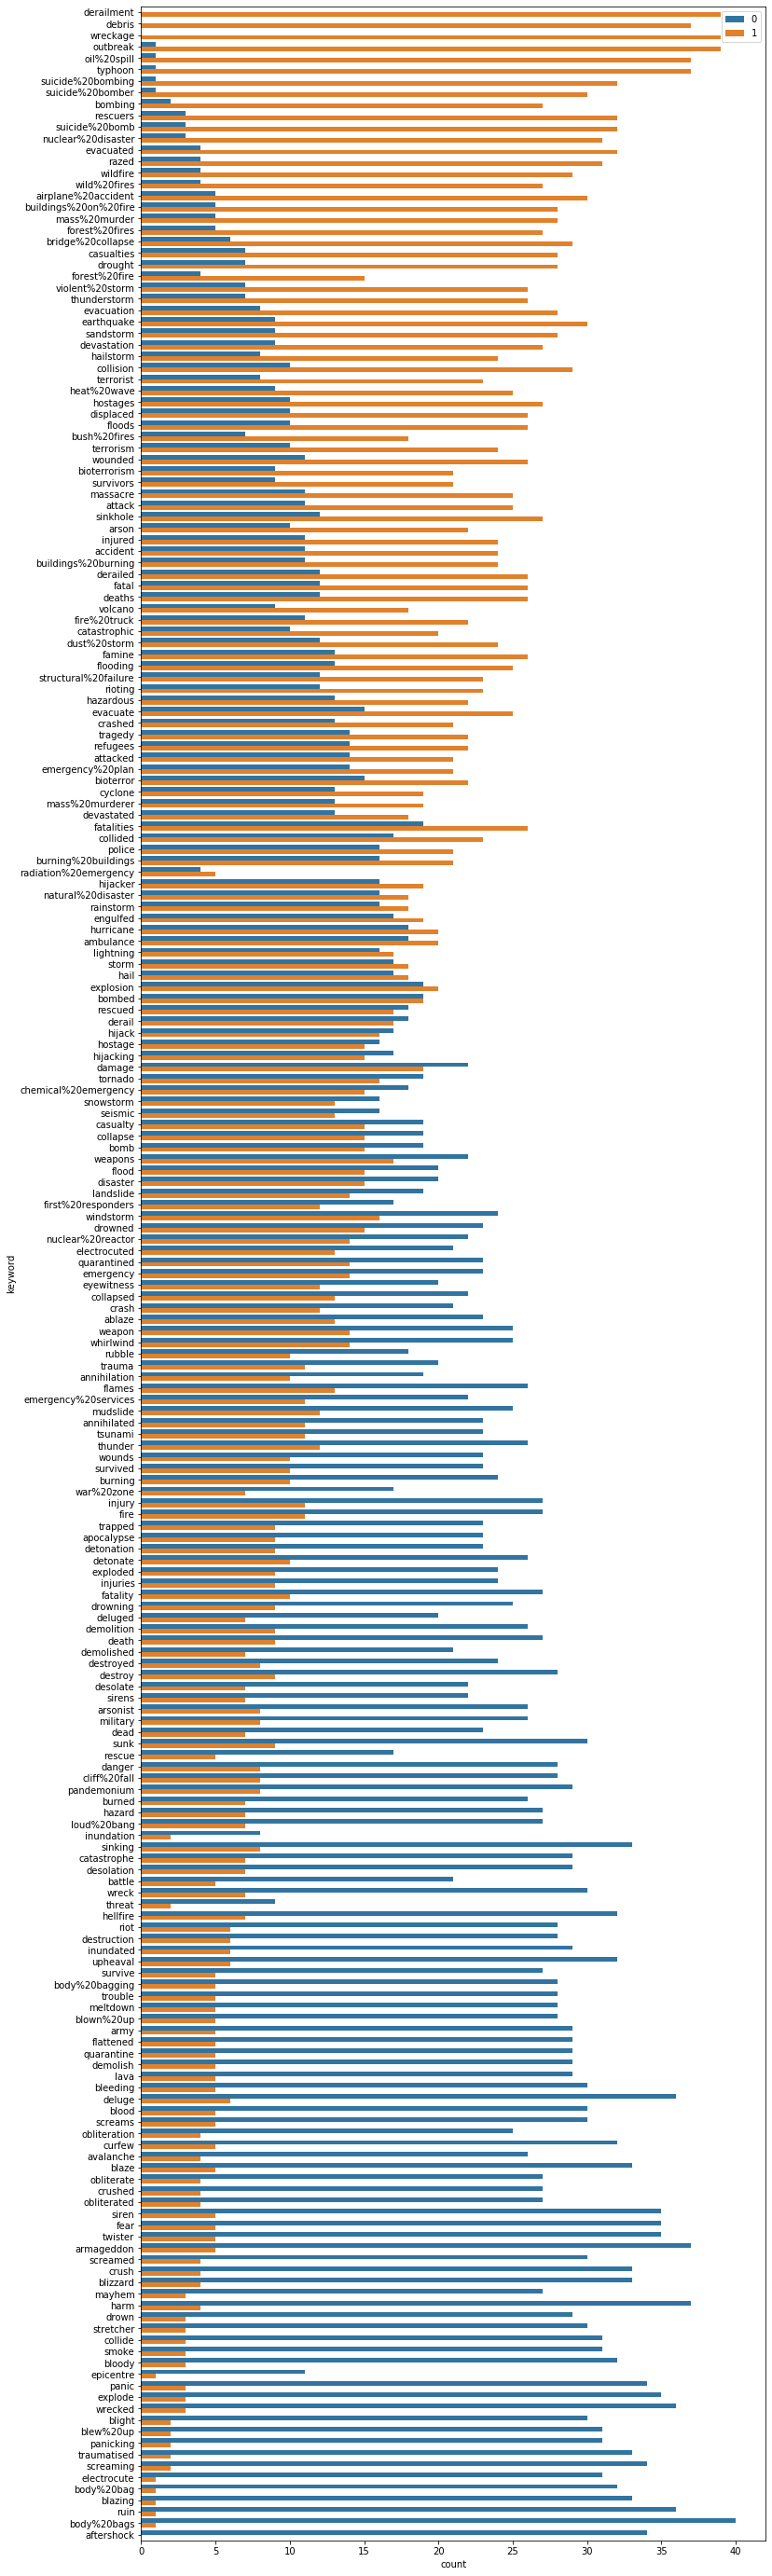

In [64]:
fig, ax = plt.subplots(figsize=(12, 50))
train_df['keyword_mean'] = train_df.groupby('keyword')['target'].transform('mean')
sns.countplot(y=train_df.sort_values(by='keyword_mean', ascending=False)['keyword'],
              hue=train_df.sort_values(by='keyword_mean', ascending=False)['target'],
              ax=ax)
ax.tick_params(axis='y', labelsize=10)
ax.legend(loc='upper right')